<a href="https://colab.research.google.com/github/prachiwadekar/Portfolio/blob/main/SVHN_Digit_Recognition_PW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Project: Street View Housing Number Digit Recognition**

# **Marks: 60**

--------------
## **Context**
--------------

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve the map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents.

----------------
## **Objective**
----------------

Our objective is to predict the number depicted inside the image by using Artificial or Fully Connected Feed Forward Neural Networks and Convolutional Neural Networks. We will go through various models of each and finally select the one that is giving us the best performance.

-------------
## **Dataset**
-------------
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been applied on the dataset.

## **Mount the drive**

Let us start by mounting the Google drive. You can run the below cell to mount the Google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Importing the necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split

# Importing Deep Learning Libraries

from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
import h5py

**Let us check the version of tensorflow.**

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.20.0


## **Load the dataset**

- Let us now load the dataset that is available as a .h5 file.
- Split the data into the train and the test dataset.

In [ ]:
#storing the path of the data from the Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/SVHN_single_grey1.h5'
#extract the files from the sip file
path = '/content/drive/MyDrive/Colab Notebooks/SVHN_single_grey1.h5'
with h5py.File(path, 'r') as f:
    X_train = f['X_train'][:]
    y_train = f['y_train'][:]
    X_val   = f['X_val'][:]
    y_val   = f['y_val'][:]
    X_test  = f['X_test'][:]
    y_test  = f['y_test'][:]

Check the number of images in the training and the testing dataset.

In [ ]:
#identifying how many images are in training, validation and test datasets
print("Number of training images:", X_train.shape[0])
print("Number of validation images:", X_val.shape[0])
print("Number of test images:", X_test.shape[0])

Number of training images: 42000
Number of validation images: 60000
Number of test images: 18000


**Observation:**

1. We successfully mounted the drive and imported the necessary deep learning libraries.
2. We are using the Tensorflow version 2.20.0.
3. We have loaded the dataset and split it out into training and test; we have 42,000 images in training set, 60,0000 images in the validation set and 18,000 images in test set.



## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

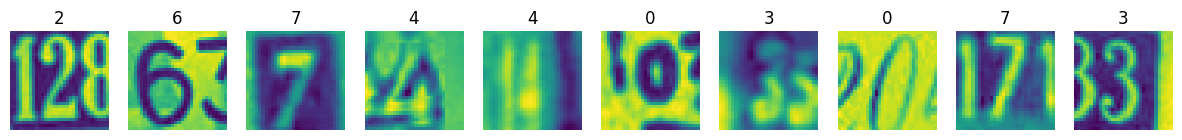

First 10 labels in y_train: [2 6 7 4 4 0 3 0 7 3]


In [ ]:
# Visualizing the first 10 training images and their labels
plt.figure(figsize=(15, 3))

for i in range(10):
    img = X_train[i]

    # If grayscale stored as (1, H, W), transpose to (H, W, 1)
    if img.shape[0] == 1 or img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))

    plt.subplot(1, 10, i + 1)

    if img.shape[-1] == 1:  # grayscale
        plt.imshow(img.squeeze(), cmap='gray')
    else:                   # RGB
        plt.imshow(img.astype("uint8"))

    plt.title(int(y_train[i]))
    plt.axis("off")

plt.show()

# Print the first 10 labels
print("First 10 labels in y_train:", y_train[:10].flatten())

## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

Shape of first training image: (32, 32)
Pixel values of first training image:
 [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


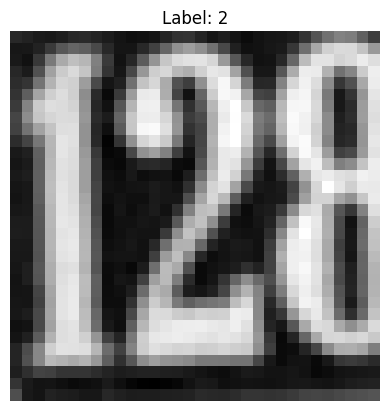

In [ ]:
first_image = X_train[0]

print("Shape of first training image:", first_image.shape)
print("Pixel values of first training image:\n", first_image)

plt.imshow(first_image.squeeze(), cmap='gray')
plt.title(f"Label: {int(y_train[0])}")
plt.axis("off")
plt.show()

### **Normalize the train and the test data**

In [ ]:
X_train = X_train.astype('float32') / 255.0
X_val   = X_val.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

Print the shapes of Training and Test data

In [ ]:
print("Shape of X_train after normalization:", X_train.shape)
print("Shape of X_val after normalization:", X_val.shape)
print("Shape of X_test after normalization:", X_test.shape)

Shape of X_train after normalization: (42000, 32, 32)
Shape of X_val after normalization: (60000, 32, 32)
Shape of X_test after normalization: (18000, 32, 32)


### **One-hot encode output**

In [ ]:
num_classes = 10  # digits 0-9
y_train_ohe = to_categorical(y_train, num_classes=num_classes)
y_val_ohe   = to_categorical(y_val, num_classes=num_classes)
y_test_ohe  = to_categorical(y_test, num_classes=num_classes)

print("Shape of one-hot encoded y_train:", y_train_ohe.shape)
print("Shape of one-hot encoded y_val:", y_val_ohe.shape)
print("Shape of one-hot encoded y_test:", y_test_ohe.shape)

Shape of one-hot encoded y_train: (42000, 10)
Shape of one-hot encoded y_val: (60000, 10)
Shape of one-hot encoded y_test: (18000, 10)


**Observation:**


1. We visualized the first 10 labels in y_train: [2 6 7 4 4 0 3 0 7 3]. Labels come back as expected with no surprises.
2. Closer look at the first training image tells us we are looking at images which are 32x32 pixels.
3. We have successfully completed one hot encoding so that our neural network can process output variables as a single integer into a vector where only the correct class index is 1, and all others are 0.



## **Model Building**

Now that we have done the data preprocessing, let's build an ANN model.

### Fix the seed for random number generators

In [ ]:
import random

# --- Fix seeds for reproducibility ---
seed_value = 42
# 1. Python built-in random module
random.seed(seed_value)
# 2. NumPy
np.random.seed(seed_value)
# 3. TensorFlow
tf.random.set_seed(seed_value)
# 4. For some operations, you can also set environment variable for additional determinism
os.environ['PYTHONHASHSEED'] = str(seed_value)
print("Random seeds fixed.")


Random seeds fixed.


### **Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **64 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **32 nodes and the relu activation**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_1 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train an ANN model as per the above mentioned architecture.**

In [ ]:
# --- Function to build the model ---
def nn_model_1(input_shape=(1024,), num_classes=10):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),  # First hidden layer
        Dense(32, activation='relu'),                            # Second hidden layer
        Dense(num_classes, activation='softmax')                # Output layer
    ])

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

# --- Call the function to create the model ---
# Flatten X_train images first (32*32 = 1024)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat   = X_val.reshape(X_val.shape[0], -1)

model1 = nn_model_1(input_shape=(1024,), num_classes=10)

# --- Print summary ---
model1.summary()

# --- Fit the model ---
history1 = model1.fit(
    X_train_flat, y_train_ohe,
    validation_split=0.2,
    batch_size=128,
    epochs=20,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,010 (265.66 KB)

 Trainable params: 68,010 (265.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1059 - loss: 25.8865 - val_accuracy: 0.1017 - val_loss: 5.0502
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1064 - loss: 4.7929 - val_accuracy: 0.0977 - val_loss: 2.3037
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0997 - loss: 2.3055 - val_accuracy: 0.0977 - val_loss: 2.3033
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0999 - loss: 2.3040 - val_accuracy: 0.0977 - val_loss: 2.3030
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0999 - loss: 2.3033 - val_accuracy: 0.0977 - val_loss: 2.3029
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0971 - loss: 2.3028 - val_accuracy: 0.0975 - val_loss: 2.3030
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0998 - loss: 2.3028 - val_accuracy: 0.0975 - val_loss: 2.3029
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0999 - loss: 2.3027 - val_accuracy: 0

### **Plot the Training and Validation Accuracies and write down your Observations.**

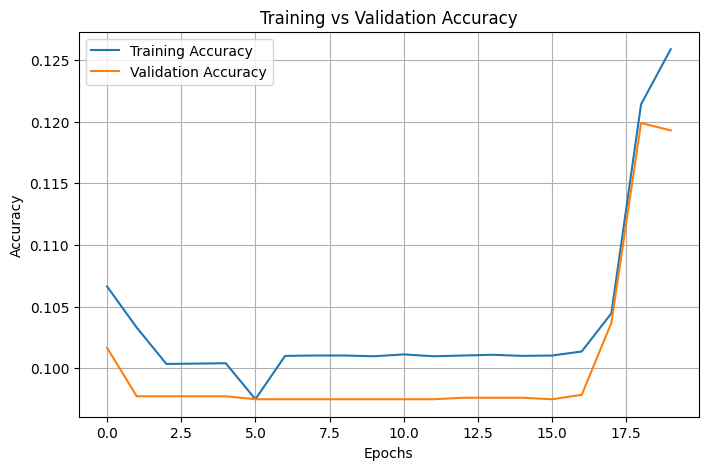

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Observations:**

accuracy: 0.1251      → 12.51% on the training set
val_accuracy: 0.1193  → 11.93% on the validation set
loss: 2.2535
val_loss: 2.2787
12% accuracy is extremely low — basically random guessing for 10 classes (10% expected if pure chance).

Training and validation accuracies are almost identical → model did not learn anything useful.

Loss is still high (2.25+), which aligns with poor predictions.

This could be happening because this is an artificial neural network on flattened images. Also the model is too small with just two hidden layers.

We can also clearly see overfitting since the accuracy on the validation dataset begins to drop beyond epoch 18.

Let's build one more model with higher complexity and see if we can improve the performance of the model.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [ ]:
from tensorflow.keras import backend as K

# --- Clear previous model from Keras backend ---
K.clear_session()
# --- Fix seeds for reproducibility ---
seed_value = 42
# 1. Python built-in random module
random.seed(seed_value)
# 2. NumPy
np.random.seed(seed_value)
# 3. TensorFlow
tf.random.set_seed(seed_value)
# 4. Environment variable for hash-based operations
os.environ['PYTHONHASHSEED'] = str(seed_value)
print("Previous model cleared and random seeds fixed.")

Previous model cleared and random seeds fixed.


### **Second Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **256 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **128 nodes and the relu activation**
 - Add the **Dropout layer with the rate equal to 0.2**
 - Third hidden layer with **64 nodes and the relu activation**
 - Fourth hidden layer with **64 nodes and the relu activation**
 - Fifth hidden layer with **32 nodes and the relu activation**
 - Add the **BatchNormalization layer**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 -Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.0005), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_2 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the new ANN model as per the above mentioned architecture**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam

# --- Function to build the more complex ANN ---
def nn_model_2(input_shape=(1024,), num_classes=10):
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape),  # First hidden layer
        Dense(128, activation='relu'),                            # Second hidden layer
        Dropout(0.2),                                             # Dropout layer
        Dense(64, activation='relu'),                             # Third hidden layer
        Dense(64, activation='relu'),                             # Fourth hidden layer
        Dense(32, activation='relu'),                             # Fifth hidden layer
        BatchNormalization(),                                     # Batch normalization
        Dense(num_classes, activation='softmax')                 # Output layer
    ])

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )

    return model

# --- Flatten the images ---
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat   = X_val.reshape(X_val.shape[0], -1)

# --- Create the model ---
model2 = nn_model_2(input_shape=(1024,), num_classes=10)

# --- Print model summary ---
model2.summary()

# --- Fit the model ---
history2 = model2.fit(
    X_train_flat, y_train_ohe,
    validation_split=0.2,
    batch_size=128,
    epochs=30,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,250 (1.18 MB)

 Trainable params: 310,186 (1.18 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1050 - loss: 2.5269 - val_accuracy: 0.1013 - val_loss: 2.3172
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1057 - loss: 2.3136 - val_accuracy: 0.1146 - val_loss: 2.3006
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1161 - loss: 2.3003 - val_accuracy: 0.0985 - val_loss: 2.3057
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1103 - loss: 2.2991 - val_accuracy: 0.1670 - val_loss: 2.2051
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1687 - loss: 2.1621 - val_accuracy: 0.1829 - val_loss: 2.1090
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1816 - loss: 2.1101 - val_accuracy: 0.1769 - val_loss: 2.0902
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1948 - loss: 2.0788 - val_accuracy: 0.2354 - val_loss: 2.0398
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2620 - loss: 1.9792 - val_accuracy: 0

### **Plot the Training and Validation Accuracies and write down your Observations.**

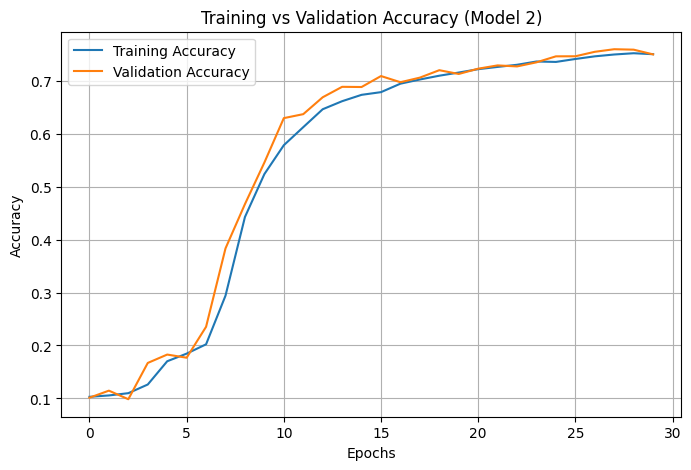

In [ ]:
# --- Plot Training and Validation Accuracy for model2 ---
plt.figure(figsize=(8,5))
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Model 2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Observations:**

accuracy: 0.7535       → 75.35% on the training set
val_accuracy: 0.7502   → 75.02% on the validation set
loss: 0.7822
val_loss: 0.8044

No overfitting is observed from the graph since gap between training and validation accuracy is tiny (~0.3%)

First simple ANN achieved ~12% → basically random guessing. This higher-complexity ANN reached ~75% → a major improvement. Adding more layers, more neurons, Dropout, and BatchNormalization clearly helped the model learn better features from flattened images.

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# --- Flatten the test images ---
X_test_flat = X_test.reshape(X_test.shape[0], -1)
# --- Make predictions ---
y_pred_probs = model2.predict(X_test_flat)

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [ ]:
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels


### **Print the classification report and the confusion matrix for the test predictions. Write your observations on the final results.**

Classification Report:

              precision    recall  f1-score   support

           0     0.8677    0.7337    0.7951      1814
           1     0.6831    0.8277    0.7485      1828
           2     0.7448    0.7770    0.7606      1803
           3     0.7565    0.6975    0.7258      1719
           4     0.8214    0.8223    0.8218      1812
           5     0.7427    0.7381    0.7404      1768
           6     0.8094    0.7489    0.7780      1832
           7     0.6748    0.8617    0.7569      1808
           8     0.7541    0.7141    0.7336      1812
           9     0.8420    0.6973    0.7629      1804

    accuracy                         0.7623     18000
   macro avg     0.7696    0.7618    0.7624     18000
weighted avg     0.7698    0.7623    0.7626     18000



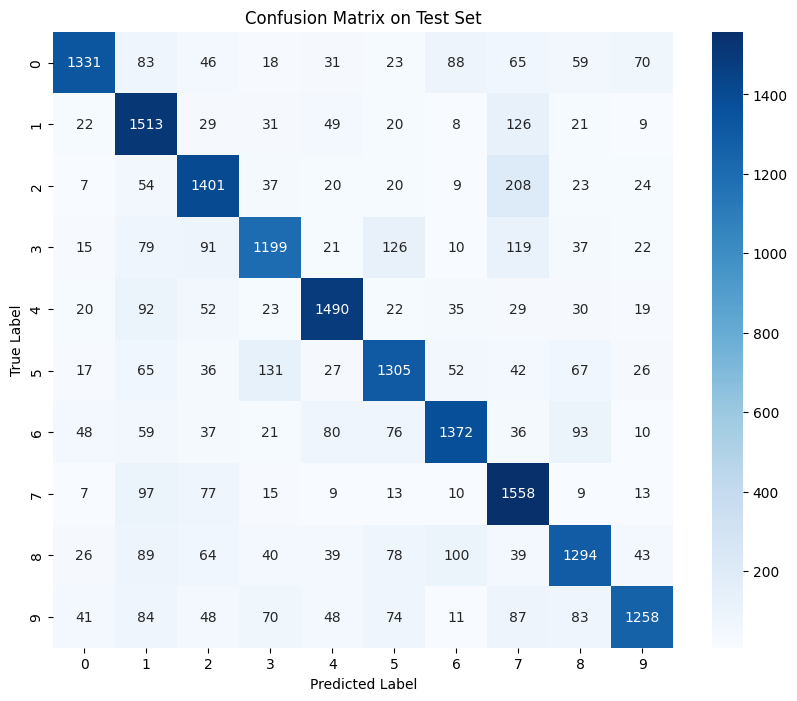

In [ ]:
# --- True labels ---
y_true = y_test.flatten()
# --- Classification report ---
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

# --- Confusion matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

**Final Observations:**

With a 76% accuracy this second ANN performs reasonably well on most digits; but some digits may still be confused, as can be clearly seen in the heatmap.



## **Using Convolutional Neural Networks**

### **Load the dataset again and split the data into the train and the test dataset.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#storing the path of the data from the Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/SVHN_single_grey1.h5'
#extract the files from the sip file
path = '/content/drive/MyDrive/Colab Notebooks/SVHN_single_grey1.h5'
with h5py.File(path, 'r') as f:
    X_train = f['X_train'][:]
    y_train = f['y_train'][:]
    X_val   = f['X_val'][:]
    y_val   = f['y_val'][:]
    X_test  = f['X_test'][:]
    y_test  = f['y_test'][:]

Mounted at /content/drive


Check the number of images in the training and the testing dataset.

In [ ]:
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (42000, 32, 32)
Test set shape: (18000, 32, 32)


**Observation:**

There are 42,000 images in training set and 18,000 images in test set. Every image is of 32x32 pixel. This is a large enough dataset to train a CNN effectively.


## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Reshape the train and the test dataset because we always have to give a 4D array as input to CNNs.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [ ]:
# --- Print the shape and pixel array of the first training image ---
print("Shape of first training image:", X_train[0].shape)
print("Pixel values of first training image:\n", X_train[0])

Shape of first training image: (32, 32)
Pixel values of first training image:
 [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


Reshape the dataset to be able to pass them to CNNs. Remember that we always have to give a 4D array as input to CNNs

In [ ]:
def reshape_for_cnn(X):
    if X.shape[1] == 1 or X.shape[1] == 3:
        X = np.transpose(X, (0, 2, 3, 1))
    return X

X_train = reshape_for_cnn(X_train)
X_test  = reshape_for_cnn(X_test)

# Print new shapes
print("Reshaped X_train shape (for CNN):", X_train.shape)
print("Reshaped X_test shape (for CNN):", X_test.shape)

Reshaped X_train shape (for CNN): (42000, 32, 32)
Reshaped X_test shape (for CNN): (18000, 32, 32)


Normalize inputs from 0-255 to 0-1

In [ ]:
# Normalize train and test images
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

Print New shape of Training and Test

In [ ]:
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (42000, 32, 32)
Test set shape: (18000, 32, 32)


### **One-hot encode the labels in the target variable y_train and y_test.**

In [ ]:
num_classes = 10  # digits 0-9

# One-hot encode labels
y_train_ohe = to_categorical(y_train, num_classes=num_classes)
y_test_ohe  = to_categorical(y_test, num_classes=num_classes)

# Confirm
print("First 10 one-hot encoded labels:\n", y_train_ohe[:10])

First 10 one-hot encoded labels:
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


**Observation:**
Images are 32x32 pixel, this might be convenient for fast cnn training. Additionally, the dataset is clean, normalized and properly formatted.

## **Model Building**

Now that we have done data preprocessing, let's build a CNN model.
Fix the seed for random number generators

In [ ]:
# --- Clear previous models from memory ---
K.clear_session()
# --- Fix seed for reproducibility ---
seed_value = 42
# 1. Python built-in random module
random.seed(seed_value)
# 2. NumPy
np.random.seed(seed_value)
# 3. TensorFlow
tf.random.set_seed(seed_value)
# 4. Environment variable for hash-based operations
os.environ['PYTHONHASHSEED'] = str(seed_value)
print("Random seeds fixed and previous models cleared.")

Random seeds fixed and previous models cleared.


### **Model Architecture**
- **Write a function** that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Another **LeakyRelu** with the **slope equal to 0.1**
 - A **max-pooling layer** with a **pool size of 2x2**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_1 and store the output in a new variable.
- Print the summary of the model.
- Fit the model on the training data with a **validation split of 0.2, batch size = 32, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train a CNN model as per the above mentioned architecture.**

In [ ]:
# --- Function to build the CNN ---
def cnn_model_1(input_shape=(32, 32, 1), num_classes=10):
    model = Sequential([
        # First convolutional layer
        Conv2D(16, (3, 3), padding='same', input_shape=input_shape),
        LeakyReLU(alpha=0.1),
        # Second convolutional layer
        Conv2D(32, (3, 3), padding='same'),
        LeakyReLU(alpha=0.1),
        # MaxPooling
        MaxPooling2D(pool_size=(2, 2)),
        # Flatten
        Flatten(),
        # Dense layer
        Dense(32),
        LeakyReLU(alpha=0.1),
        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    return model
# --- Create the CNN model ---
model_cnn1 = cnn_model_1(input_shape=(32, 32, 1), num_classes=10)
# --- Print summary ---
model_cnn1.summary()
# --- Fit the model ---
history_cnn1 = model_cnn1.fit(
    X_train, y_train_ohe,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       262,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,306 (1.02 MB)

 Trainable params: 267,306 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.3421 - loss: 6.1110 - val_accuracy: 0.7698 - val_loss: 0.8243
Epoch 2/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.7707 - loss: 0.7857 - val_accuracy: 0.8017 - val_loss: 0.7086
Epoch 3/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.8224 - loss: 0.6071 - val_accuracy: 0.8154 - val_loss: 0.6571
Epoch 4/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.8450 - loss: 0.5293 - val_accuracy: 0.8362 - val_loss: 0.6143
Epoch 5/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.8576 - loss: 0.4814 - val_accuracy: 0.8319 - val_loss: 0.6336
Epoch 6/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.8694 - loss: 0.4423 - val_accuracy: 0.8426 - val_loss: 0.6320
Epoch 7/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.8753 - loss: 0.4109 - val_accuracy: 0.8321 - val_loss: 0.7119
Epoch 8/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.8857 -

### **Plot the Training and Validation Accuracies and Write your observations.**

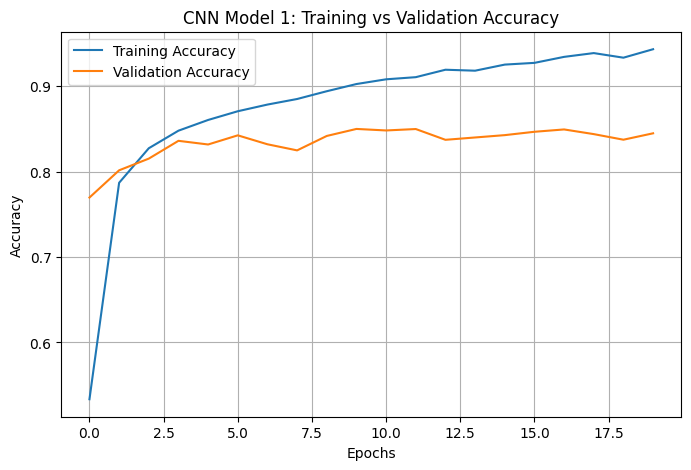

In [ ]:
# --- Plot training and validation accuracy ---
plt.figure(figsize=(8,5))
plt.plot(history_cnn1.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn1.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model 1: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Observations:**

While the accuracy of the CNN model is far better than the previous ANN (>85% on the validation set). the training accuracy is much higher than the validation accuracy suggesting overfitting.

Let's build another model and see if we can get a better model with generalized performance.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [ ]:
# --- Clear previous Keras session ---
K.clear_session()

# --- Fix seeds for reproducibility ---
seed_value = 42

# 1. Python random module
random.seed(seed_value)

# 2. NumPy
np.random.seed(seed_value)

# 3. TensorFlow
tf.random.set_seed(seed_value)

# 4. Environment variable for hash-based operations
os.environ['PYTHONHASHSEED'] = str(seed_value)

print("Previous models cleared and random seeds fixed.")

Previous models cleared and random seeds fixed.


### **Second Model Architecture**

- Write a function that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add **LeakyRelu** with the **slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - Third Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Fourth Convolutional layer **64 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **dropout layer with the rate equal to 0.5**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_2 and store the model in a new variable.
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the second CNN model as per the above mentioned architecture.**

In [ ]:
# --- Function to build the second CNN ---
def cnn_model_2(input_shape=(32, 32, 1), num_classes=10):
    model = Sequential([
        # First Convolutional Block
        Conv2D(16, (3,3), padding='same', input_shape=input_shape),
        LeakyReLU(alpha=0.1),

        # Second Convolutional Layer
        Conv2D(32, (3,3), padding='same'),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(),

        # Third Convolutional Layer
        Conv2D(32, (3,3), padding='same'),
        LeakyReLU(alpha=0.1),

        # Fourth Convolutional Layer
        Conv2D(64, (3,3), padding='same'),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(),

        # Flatten and Dense Layers
        Flatten(),
        Dense(32),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

# --- Create the CNN model ---
model_cnn2 = cnn_model_2(input_shape=(32, 32, 1), num_classes=10)

# --- Print model summary ---
model_cnn2.summary()

# --- Fit the model ---
history_cnn2 = model_cnn2.fit(
    X_train, y_train_ohe,
    validation_split=0.2,
    batch_size=128,
    epochs=30,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,362 (642.04 KB)

 Trainable params: 164,170 (641.29 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 96s 357ms/step - accuracy: 0.3368 - loss: 1.9104 - val_accuracy: 0.8131 - val_loss: 0.6612
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 92s 351ms/step - accuracy: 0.7863 - loss: 0.7003 - val_accuracy: 0.8723 - val_loss: 0.4507
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 92s 350ms/step - accuracy: 0.8278 - loss: 0.5709 - val_accuracy: 0.8789 - val_loss: 0.4262
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 91s 344ms/step - accuracy: 0.8479 - loss: 0.5086 - val_accuracy: 0.8794 - val_loss: 0.4384
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 91s 344ms/step - accuracy: 0.8599 - loss: 0.4689 - val_accuracy: 0.8900 - val_loss: 0.3869
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 90s 344ms/step - accuracy: 0.8711 - loss: 0.4213 - val_accuracy: 0.8965 - val_loss: 0.3787
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 89s 340ms/step - accuracy: 0.8788 - loss: 0.3992 - val_accuracy: 0.8987 - val_loss: 0.3709
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 90s 341ms/step - accuracy: 0.8916 - loss: 0

### **Plot the Training and Validation accuracies and write your observations.**

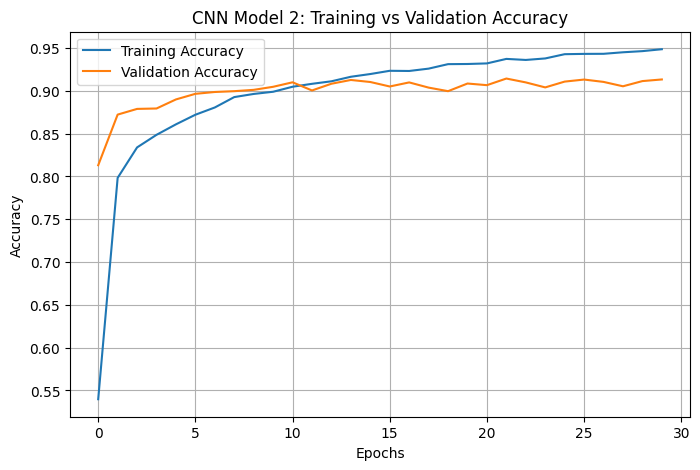

In [ ]:
# --- Plot training and validation accuracy ---
plt.figure(figsize=(8,5))
plt.plot(history_cnn2.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn2.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model 2: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Observations:**

accuracy: 0.9468 - loss: 0.1584 - val_accuracy: 0.9133 - val_loss: 0.4824

Training accuracy of ~95% and validation accuracy of 91% is better than the previous CNN model.

However, we can still see some overfitting as accuracy for the validation set starts to dip beyond epoch 10.

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

### **Make predictions on the test data using the second model.**

In [ ]:
# --- Make predictions on test set ---
y_pred_probs = model_cnn2.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector, but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [ ]:
# --- Convert one-hot encoded labels back to integers ---
y_test_labels = np.argmax(y_test_ohe, axis=1)

### **Write your final observations on the performance of the model on the test data.**

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1814
           1       0.84      0.93      0.89      1828
           2       0.93      0.92      0.93      1803
           3       0.91      0.88      0.89      1719
           4       0.92      0.93      0.92      1812
           5       0.91      0.92      0.92      1768
           6       0.89      0.91      0.90      1832
           7       0.95      0.90      0.93      1808
           8       0.91      0.89      0.90      1812
           9       0.94      0.89      0.91      1804

    accuracy                           0.91     18000
   macro avg       0.91      0.91      0.91     18000
weighted avg       0.91      0.91      0.91     18000

Confusion Matrix:

[[1705   27    6    4   12    1   25    7    7   20]
 [  20 1708    8   10   41    3    7   20    9    2]
 [  12   25 1662   15   20    4    5   22   17   21]
 [   6   35   23 1506   15   60   22   

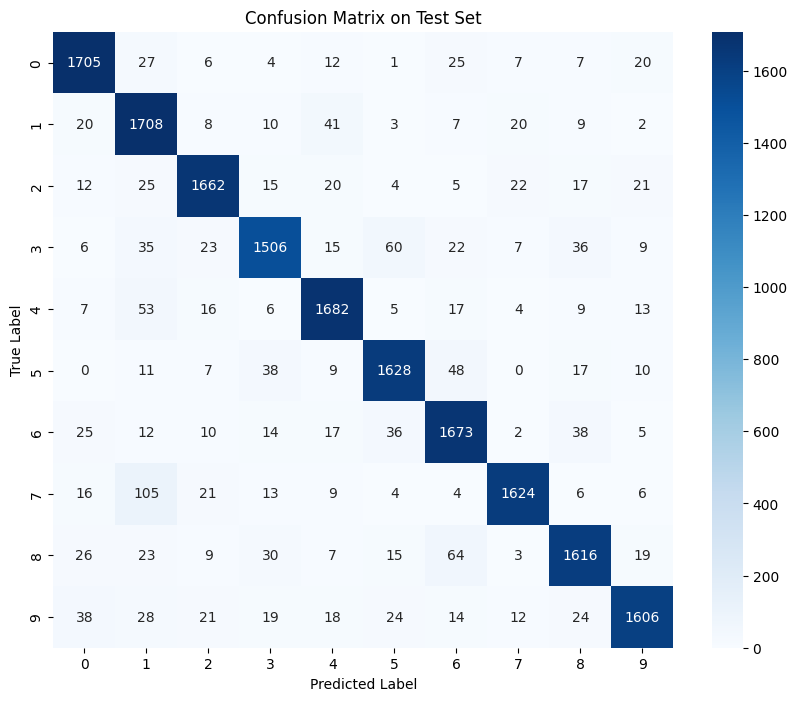

In [ ]:
# --- Classification report ---
print("Classification Report:\n")
print(classification_report(y_test_labels, y_pred_labels))

# --- Confusion matrix ---
cm = confusion_matrix(y_test_labels, y_pred_labels)
print("Confusion Matrix:\n")
print(cm)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

**Final Observations:**

A 91% accuracy on the final CNN model tells me this model is better than the prior CNN model and significantly better than ANN models (76% accuracy on test data) that we built.
The overfitting pattern after epoch 10 makes it clear that the epochs beyond ~10 are essentially "wasted" because they do not improve validation accuracy.
